In [2]:
%matplotlib inline

In [3]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vtk_rw import read_vtk
import seaborn as sns
from plotting import plot_surf_stat_map
import matplotlib

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
def calculate_normals(vertices, faces):
    triangles = vertices[faces]
    face_normals = np.cross( triangles[::,1 ] - triangles[::,0]  , triangles[::,2 ] - triangles[::,0] )
    face_normals /= 2 # weighting by surface area of the triangle, which is half the length of the normal
    
    vertex_normals = np.zeros(vertices.shape, dtype=vertices.dtype)
    vertex_count = np.zeros(vertices.shape[0])
    
    for face in range(faces.shape[0]):
        vertex_normals[faces[face]] += face_normals[face]
        vertex_count[faces[face]] += 1
   
    # divide by actual number of faces
    vertex_normals /= vertex_count[:, np.newaxis]
    
    return vertex_normals

In [5]:
def compare_normals(normals_a, normals_b):
    # normalize normals
    normals_a /= np.linalg.norm(normals_a, axis=1)[:,np.newaxis]
    normals_b /= np.linalg.norm(normals_b, axis=1)[:,np.newaxis]
    
    if np.any(np.isnan(normals_a)):
        raise ValueError('NaN in first set of normals')
    elif np.any(np.isnan(normals_b)):
        raise ValueError('NaN in second set of normals')
    else:
        pass
    
    # calculate angle between each pair of normals in radians
    diff_dot = np.zeros((normals_a.shape[0],))
    diff_rad = np.zeros((normals_a.shape[0],))
    for i in range(normals_a.shape[0]):
        diff_dot[i] = np.dot(normals_a[i], normals_b[i])
    # if the dot product ends up being a very small float point bigger than 1, np.arccos returns NaN
    # therefore set those cases to 1
    diff_dot[np.where(diff_dot>1)] = 1.
    diff_rad = np.arccos(diff_dot)
    
    # transform to degree angle
    diff_deg = diff_rad  * (180/np.pi)
    
    return diff_rad, diff_deg

In [6]:
cutoff_angle=(np.pi/2)
simple_vertices, simple_faces, _ = read_vtk('/scr/ilz3/myelinconnect/groupavg/indv_space/BP4T/lowres_rh_d_def.vtk')
complex_vertices, complex_faces, _ = read_vtk('/scr/ilz3/myelinconnect/struct/surf_rh/orig/mid_surface/BP4T_rh_mid.vtk')

In [7]:
from bintrees import FastAVLTree
import scipy.spatial as spatial
from utils import log

# calculate normals for simple and complex vertices
simple_normals = calculate_normals(simple_vertices, simple_faces)
complex_normals = calculate_normals(complex_vertices, complex_faces)

# prepare array to store seeds
voronoi_seed_idx = np.zeros((simple_vertices.shape[0],), dtype='int64')-1

# initialize with all vertices and small number of neighbours
remaining_idxs = range(simple_vertices.shape[0])
neighbours = 100

while np.any(voronoi_seed_idx==-1):

inaccuracy, mapping  = spatial.KDTree(complex_vertices).query(simple_vertices[remaining_idxs], k=neighbours)

# create tidy long-format lists
simple_idxs = np.asarray([neighbours*[simple_idx] for simple_idx in remaining_idxs]).flatten()
candidate_idxs = mapping.flatten()

# for each vertex pair calculate the angle between their normals
diff_normals, _ = compare_normals(simple_normals[simple_idxs], complex_normals[candidate_idxs])
diff_normals = diff_normals.reshape(mapping.shape)
diff_euclid = inaccuracy

# set values with angele > cutoff to nan so they can easily be ignored subsequently
mask = np.where(diff_normals>cutoff_angle)
diff_normals[mask] = np.nan
diff_euclid[mask] = np.nan

# calculate scores taking into account angle and distance of each vertex pair
scores = (diff_normals-np.nanmean(diff_normals)) + (diff_euclid-np.nanmean(diff_euclid))

# get the candidate with the best score for each vertex (allowing repetitions)
for row in range(scores.shape[0]):
    idx = np.where(scores[row] == np.nanmin(scores[row]))[0]
    voronoi_seed_idx[idx] = mapping[row, idx]

# find those vertices that didn't have a single valid candidate in the first round
remaining_idxs = np.where(voronoi_seed_idx==-1)[0]

neighbours *= 500

In [25]:
np.argmin(scores, axis=1)[50]

16

In [ ]:
scores

In [45]:
np.where(scores[89] == np.nanmin(scores[89]))

(array([], dtype=int64),)

In [27]:
test_scores = np.nanmin(scores,axis=1)

In [38]:
np.where(scores[0] == np.nanmin(scores[0]))[0]

array([4])

In [37]:
mapping[0,4]

3456

In [29]:
for row in range(scores.shape[0]):
    idx = np.where(scores[row] == np.nanmin(scores[row]))[0][0]
    voronoi_seed_idx[idx] = mapping[row, idx]
    

(array([4]),)

In [24]:
np.where(np.isnan(scores))

(array([   50,    50,    50, ..., 75546, 75546, 75546]),
 array([16, 17, 27, ..., 55, 85, 91]))

In [26]:
scores[50,16]

nan

In [91]:
plot_outliers = np.zeros(simple_vertices.shape[0],)

In [118]:
np.ones_like(plot_outliers) * np.nan

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [94]:
plot_outliers[np.where(np.isnan(mins))] = 1

In [96]:
sulc = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_sulc.npy')

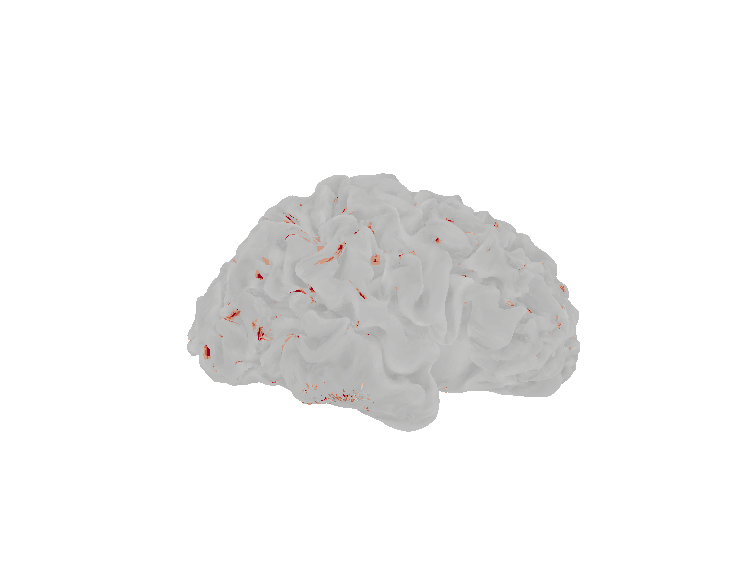

In [98]:
sns.set_style('white')
plot_orig = plot_surf_stat_map(simple_vertices, simple_faces, stat_map=plot_outliers, bg_map=sulc, bg_on_stat=True, 
                               darkness=0.4,elev=180,azim=0, figsize=(13,10))

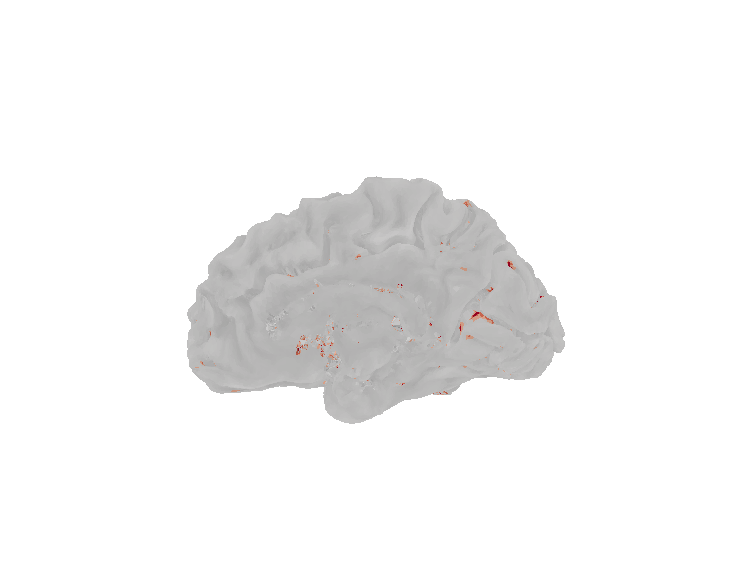

In [100]:
sns.set_style('white')
plot_orig = plot_surf_stat_map(simple_vertices, simple_faces, stat_map=plot_outliers, bg_map=sulc, bg_on_stat=True, 
                               darkness=0.4,elev=180,azim=180, figsize=(13,10))